In [1]:
# ML_in_Finance_FCW
# Author: Matthew Dixon
# Version: 1.0 (06.05.2020)
# License: MIT
# Email: matthew.dixon@iit.edu
# Notes: tested on Mac OS X with Python 3.6.9 and the following packages:
# matplotlib=3.1.3, numpy=1.18.1, tqdm=4.46.0
# Citation: Please cite the following reference if this notebook is used for research purposes:
# Bilokon P., Dixon M.F. and Halperin I., Machine Learning in Finance: From Theory to Practice, Springer Graduate textbook Series, 2020. 

In [2]:
# Adapted from the code referenced here:
# https://github.com/ShangtongZhang/reinforcement-learning-an-introduction
#######################################################################
# Copyright (C)                                                       #
# 2016-2018 Shangtong Zhang(zhangshangtong.cpp@gmail.com)             #
# 2016 Kenta Shimada(hyperkentakun@gmail.com)                         #
# Permission given to modify the code as long as you keep this        #
# declaration at the top                                              #
#######################################################################

# Financial Cliff Walking Problem

Consider an over-simplified model of a household's finances. Let $S_t$ be the amount of money the household has at time $t$. We assume for simplicity that $S_t$ can only take values in a discrete set $\{S^{(i)}\}_{i=0}^{N-1}$. 

The account has to be maintained for $T$ time steps, after which it should be closed - $T$ is the planning horizon. The zero-level $S^{(0)}=0$ is a bankruptcy level - it has to be avoided, as reaching it means inability to pay on household liabilities. 

At each step, the agent can deposit to the account $S^{(i)} \rightarrow S^{(i+1)}$ (action $a_+$), withdraw from the account $S^{(i)} \rightarrow S^{(i-1)}$, (action $a_-$), or keep the same amount $S^{(i)} \rightarrow S^{(i)}$, (action $a_0$). The initial amount in the account is zero. 

For any step before the final step $T$, if the agent moves to the zero level  $S_0 = 0$, it gets a negative reward of $-100$, and the episode terminates. Otherwise, it continues for all $T$ steps. Any action not leading to the zero level gets a negative reward of $-1$. At $T$, if the final state is $S_T>0$, the reward is $-10$, but if the account goes back to zero exactly at time $T$, i.e. $S_T=0$, then the last action gets a positive reward of $+10$. 

The learning task is to maximize the total reward over $T$ time steps. The RL agent has to learn the optimal depository policy online by trying different actions during a training episode. Note that while this is a time-dependent problem, we can map it on to a stationary problem with an episodic task and a target state, such as the original cliff walking problem in Sutton-Barto.

<img src="The-cliff-walking-task.jpg">

### Import the necessary libraries

In [4]:
import numpy as np
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt 
%matplotlib inline

# tqdm is used to show nice progress bars while the RL agent is going through its learning process.
from tqdm import tqdm 

# To silence warnings which are unnecessary
import warnings
warnings.filterwarnings('ignore')

## Setting Up

We assume $N=4$ values of possible funds in the account, and assume $T=12$ time steps. All combinations of state and time can then be represented as a two-dimensional grid of size $N\times T = 4\times 12$. A time dependent action value function $Q_t\left( s_t, a_t\right)$ with three possible actions, $a_t = \left\{a_+, a_-, a_0\right\}$, can then be stored as a rank three tensor of dimension $4\times 12 \times 3$.

### Setting some global parameters

In [5]:
WORLD_HEIGHT = 4
WORLD_WIDTH = 12

In [6]:
EPSILON = 0.1 # Probability for exploration

ALPHA = 0.001 # Step size

GAMMA = 1 # Discount factor for Q-Learning, Sarsa and Expected Sarsa

We assign an integer value representing each action to a variable: `ACTION_UP` is $a_+$ (adding a deposit), `ACTION_DOWN` is $a_-$ (redeeming a deposit) and `ACTION_ZERO` is $a_0$ (leaving the account as it is).

In [7]:
ACTION_UP = 1
ACTION_DOWN = 2
ACTION_ZERO = 0
ACTIONS = [ACTION_UP, ACTION_DOWN, ACTION_ZERO]

We define the state vectors for the initial and goal states

In [8]:
START = [0, 0]
GOAL = [0, WORLD_WIDTH-1]

### Setting up the environment

In [73]:
# Step function that describes how the next state is obtained from the current state 
# and the action taken. The function returns the next state and the reward obtained.
def step(state, action):
    i, j = state

    if action == ACTION_UP:
        next_state = [min(i + 1, WORLD_HEIGHT-1), min(j + 1, WORLD_WIDTH - 1)]
    elif action == ACTION_DOWN:
        next_state = [max(i - 1, 0), min(j + 1, WORLD_WIDTH - 1)]
    elif action == ACTION_ZERO:
        next_state = [i, min(j + 1, WORLD_WIDTH - 1)]
    else:
        raise ValueError("action not recognised")
    
    # The reward is -1 for actions ACTION_UP and ACTION_DOWN. 
    # This is done to keep transactions to a minimum.
    reward = -1
    
    # ACTION_ZERO gets a zero reward since we want to minimize the number of transactions
    if action == ACTION_ZERO:
        reward = 0
    
    # Exceptions are 
    # i) If bankruptcy happens before WORLD_WIDTH time steps
    # ii) No deposit at initial state
    # iii) Redemption at initial state!
    # iv) Any action carried out from a bankrupt state
    if ((action == ACTION_DOWN and i == 1 and 1 <= j < 10) or (
        action == ACTION_ZERO and state == START) or (
        action == ACTION_DOWN and state == START )) or (
        i == 0 and 1 <= j <= 10):    
            reward = -100
        
    # Next exception is when we get to the final time step.
    if (next_state[1] == WORLD_WIDTH - 1): 
        if (next_state[0] == 0): # Action resulted in ending with zero balance in final time step
            reward = 10
        else:
            reward = -10   
        
    return next_state, reward

In [247]:
# Check some state, action pairs and the associated reward
print(step([0, 0], ACTION_UP))
print(step([2, 3], ACTION_DOWN))
print(step([1, 5], ACTION_DOWN))

([1, 1], -1)
([1, 4], -1)
([0, 6], -100)


### Set up the agent's action

In [101]:
# Choose an action based on epsilon greedy algorithm
def choose_action(state, q_value, eps=EPSILON):
    # With probability `eps', simply choose a random action - 'Exploration'
    if np.random.binomial(1, eps) == 1:
        action = np.random.choice(ACTIONS)
    # Otherwise, choose from the actions with the highest
    #  q-value for the given state - 'Exploitation'
    else:
        values_ = q_value[state[0], state[1], :]
        action = np.random.choice([action_ for action_, value_ in enumerate(values_) 
                                 if value_ == np.max(values_)])
    # From the bankrupt state there is no meaningful action, 
    # so we will assign ACTION_ZERO by convention.
    if state[0] == 0 and state[1] > 0:
        action = ACTION_ZERO
    return action
    

In [242]:
# Check some of the actions
q_value = np.zeros((WORLD_HEIGHT, WORLD_WIDTH, len(ACTIONS)))
print(choose_action([0, 2], q_value, EPSILON))

0


Observe the effect of $Q_t\left( s_t, a_t\right)$ & $\epsilon$ on the distribution of actions taken from a given state: 

In [289]:
q_value[1, 4, 2] = 1
print('action with highest q for state=[1, 4]:', np.argmax(q_value[1, 4]))
print('choices (eps=0):', *[choose_action([1, 4], q_value, 0) for i in range(10)])
print('choices (eps=1):', *[choose_action([1, 4], q_value, 1) for i in range(10)])

q_value[2, 7, 0] = 1
print('\naction with highest q for state=[2, 7]:', np.argmax(q_value[2, 7]))
print('choices (eps=0):  ', *[choose_action([2, 7], q_value, 0) for i in range(10)])
print('choices (eps=0.3):', *[choose_action([2, 7], q_value, 0.3) for i in range(10)])

action with highest q for state=[1, 4]: 2
choices (eps=0): 2 2 2 2 2 2 2 2 2 2
choices (eps=1): 0 0 0 1 1 0 1 1 1 0

action with highest q for state=[2, 7]: 0
choices (eps=0):   0 0 0 0 0 0 0 0 0 0
choices (eps=0.3): 1 0 0 0 0 1 0 0 0 0


### Set up the learning algorithms

##### Sarsa and Expected Sarsa

In [13]:
# An episode with Sarsa
# @q_value: values for state action pair, will be updated
# @expected: if True, will use expected Sarsa algorithm
# @step_size: step size for updating
# @return: total rewards within this episode
def sarsa(q_value, expected=False, step_size=ALPHA, eps=EPSILON):
    state = START
    action = choose_action(state, q_value,eps)
    rewards = 0.0
#     print('In sarsa: action = ', action)
    while (state[1] != WORLD_WIDTH-1) and not(1 <= state[1] <= 10 and state[0]==0): #why not start with one
        next_state, reward = step(state, action)
        next_action = choose_action(next_state, q_value, eps)
        rewards += reward
        if not expected:
            target = q_value[next_state[0], next_state[1], next_action]
        else:
            # calculate the expected value of new state
            target = 0.0
            q_next = q_value[next_state[0], next_state[1], :]
            best_actions = np.argwhere(q_next == np.max(q_next))
            for action_ in ACTIONS:
                if action_ in best_actions:
                    target += ((1.0 - eps) / len(best_actions) 
                               + eps / len(ACTIONS)) * q_value[next_state[0], next_state[1], action_]
                else:
                    target += eps / len(ACTIONS) * q_value[next_state[0], next_state[1], action_]
        target *= GAMMA
        q_value[state[0], state[1], action] += step_size * (
                reward + target - q_value[state[0], state[1], action])
        state = next_state
        action = next_action
    return rewards

##### Q-learning

In [14]:
# An episode with Q-Learning
# @q_value: values for state action pair, will be updated
# @step_size: step size for updating
# @return: total rewards within this episode
def q_learning(q_value, step_size=ALPHA, eps=EPSILON):
    state = START
    rewards = 0.0
    while state[1] != WORLD_WIDTH-1 and not(1 <= state[1] <= 10 and state[0]==0):
        action = choose_action(state, q_value, eps)
        next_state, reward = step(state, action)
        rewards += reward
        # Q-Learning update
        q_value[state[0], state[1], action] += step_size * (
                reward + GAMMA * np.max(q_value[next_state[0], next_state[1], :]) -
                q_value[state[0], state[1], action])
        state = next_state
    return rewards


##### Printing output of the learned policy

In [15]:
# Print optimal policy
def print_optimal_policy(q_value):
    optimal_policy = []
    for i in range(WORLD_HEIGHT-1, -1, -1):
        optimal_policy.append([])
        for j in range(0, WORLD_WIDTH):
            if [i, j] == GOAL:
                optimal_policy[-1].append('G')
                continue
            bestAction = np.argmax(q_value[i, j, :])
            
            # Action in bankrupt state has been set as Z
            if i == 0 and j > 0 and j < WORLD_WIDTH-1:
                optimal_policy[-1].append('Z')
            elif bestAction == ACTION_UP:
                # When i = WORLDHEIGHT - 1, U and Z are identical, so we will use Z
                if i == WORLD_HEIGHT-1:
                    optimal_policy[-1].append('Z')
                else:
                    optimal_policy[-1].append('U')
            elif bestAction == ACTION_DOWN:
                optimal_policy[-1].append('D')
            elif bestAction == ACTION_ZERO:
                optimal_policy[-1].append('Z')
    
    for row in optimal_policy:
        print(row)

#### Set up the epsilon decay

We decrease the value of epsilon with each epoch - epsilon must approach zero as the number of episodes increases in order to ensure that the q-value function converges to the optimum with the SARSA algorithm

The following figure demonstrates the exponential decay we are going to use.

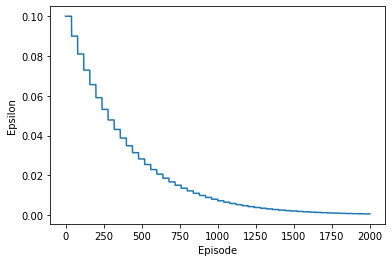

In [290]:
plt.plot([ EPSILON*((1-EPSILON)**(i//40)) for i in range(2000)])
plt.xlabel('Episode')
plt.ylabel('Epsilon');

### Running Sarsa and Q-learning 

In [246]:
# Use multiple runs instead of a single run and a sliding window
# With a single run the resulting curve is very noisy
# However, the optimal policy converges well with a single run
# Sarsa converges to the safe path, while Q-Learning converges to the optimal path
def figure_6_4():
    # Number of episodes in each run
    episodes = 2000
    EPOCH = 40

    # Perform 100 independent runs
    runs = 100
    
    # Initialise the rewards arrays
    rewards_sarsa = np.zeros(episodes)
    rewards_q_learning = np.zeros(episodes)
    for r in tqdm(range(runs)):
         # Initialise the state-action arrays 
        q_sarsa = np.zeros((WORLD_HEIGHT, WORLD_WIDTH, len(ACTIONS)))
        q_q_learning = np.copy(q_sarsa)
        
        # Update the rewards and action value arrays with each episode
        for i in range(0, episodes):
            # The value of epsilon is decremented exponentially
            #  after every EPOCH episodes
            eps = EPSILON*((1-EPSILON)**(i//EPOCH))
            rewards_sarsa[i] += sarsa(q_sarsa, eps=eps)
            rewards_q_learning[i] += q_learning(q_q_learning, eps=eps)

    # Averaging over independent runs
    rewards_sarsa /= runs
    rewards_q_learning /= runs

    # Draw reward curves
    plt.figure(figsize=(15,7))
    plt.plot(rewards_sarsa, label='Sarsa')
    plt.plot(rewards_q_learning, label='Q-Learning')
    plt.xlabel('Episodes')
    plt.ylabel('Sum of rewards during episode')
    plt.ylim([-100, 11])
    plt.legend()

    # Uncomment to save the figures:
#    plt.savefig('../images/figure_6_4.png')
#    plt.close()

    # display optimal policy
    print('Sarsa Optimal Policy:')
    print_optimal_policy(q_sarsa)
    print('Q-Learning Optimal Policy:')
    print_optimal_policy(q_q_learning)
    return q_sarsa, q_q_learning

### Running Sarsa, Expected Sarsa and Q-learning to compare their asymptotic behavior

#### Start the runs

100%|██████████| 10/10 [00:32<00:00,  3.21s/it]


Sarsa Optimal Policy:
['Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z']
['Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'D', 'U', 'Z']
['Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'D', 'Z']
['U', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'G']
Q-Learning Optimal Policy:
['Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z']
['Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'D', 'U', 'Z']
['Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'D', 'Z']
['U', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'G']


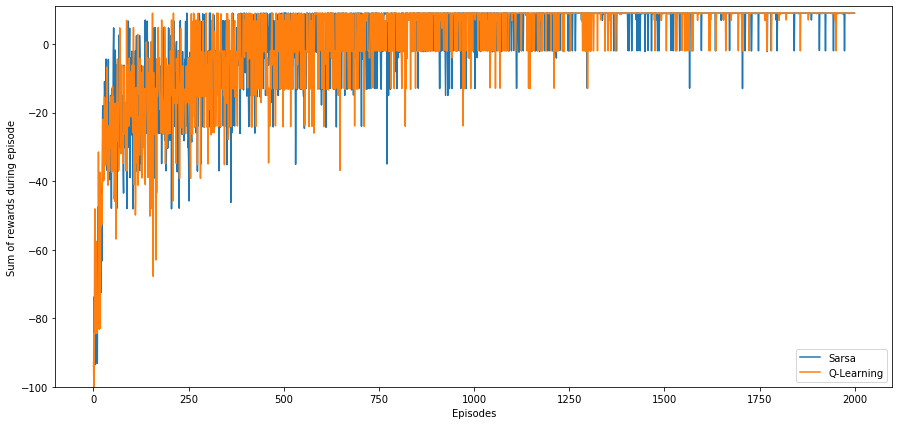

In [107]:
figure_6_4()